# Per-subtype t-test

Contrasts:

1) OVA treated (d20) compared to the controls (No treatment, PBS treated, and PBS Chase) and 
2) OVA chase (d76) compared to the controls.

## 0. Imports

In [1]:
%load_ext autoreload
%autoreload 2
import scprinter as scp
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time
import pandas as pd
import numpy as np
import os
import pickle
import torch
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
from scanpy.plotting.palettes import zeileis_28
from tqdm.contrib.concurrent import *
from tqdm.auto import *
import anndata
import scanpy as sc
import statistics as stat
import json
import csv
import re
import copy
from sklearn.preprocessing import OneHotEncoder

In [2]:
import snapatac2 as snap

In [3]:
from cuml import UMAP

In [4]:
scp.__version__

'1.0.0a'

In [5]:
# Set seed
import random
import numpy as np
random.seed(42)
np.random.seed(42)

### 0.1 Setup

In [6]:
# Specify the reference genome. This must match that of your ATAC fragments file
genome = scp.genome.mm10

genome

Define objective

In [7]:
chromVAR_or_seq2PRINT = 'chromvar'

In [8]:
# Set a seed
seed = 42
np.random.seed(seed)

## 1. Paths

### 1.1 Data directories

In [9]:
master_data_dir = '/bap/bap/collab_asthma_multiome/'

TODO: paths are messy you should clean this up soon

In [10]:
barcode_subtype_mapping_csv_file_path = os.path.join(master_data_dir, 'outputs', 'ATAC', '2_Analysis_Outputs', '1a_ChromVAR_Inputs', 'sample_barcode_predicted_cluster_df.csv')

# outputs
printer_h5ad_output_dir = os.path.join(master_data_dir, 'ATAC', '2_Analysis_Outputs', '1b_ChromVAR_scPrinter_object')
scprinter_obj_path = os.path.join(printer_h5ad_output_dir, 'Asthma_Multiome_Collab_scPrinter.h5ad')
# peak_path = os.path.join(master_data_dir, 'ATAC', '2_Analysis_Outputs', '1c_chromvar_scPrinter_MACS_peaks', 'chromVAR_preset_Asthma_Multiome_scPrinter_cleaned_merged_narrowPeak.bed')

output_dir = os.path.join(master_data_dir, 'ATAC', '2_Analysis_Outputs', f'1d_{chromVAR_or_seq2PRINT}_Outputs')
chromvar_h5ad_path = f'{output_dir}/chromvar_FigR.h5ad'

# if the output directory does not exist, create it
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [11]:
chromvar_h5ad_path

'/bap/bap/collab_asthma_multiome/ATAC/2_Analysis_Outputs/1d_chromvar_Outputs/chromvar_FigR.h5ad'

In [12]:
output_dir

'/bap/bap/collab_asthma_multiome/ATAC/2_Analysis_Outputs/1d_chromvar_Outputs'

## 2. ```scPrinter``` analysis

### 2.1 Load ChromVAR results

In [13]:
chromvar = anndata.read_h5ad(chromvar_h5ad_path)

In [14]:
chromvar

AnnData object with n_obs × n_vars = 7418 × 890

In [15]:
print(chromvar.X.shape)

(7418, 890)


In [16]:
chromvar.X[0:10, 0:10]

array([[-1.7605633 ,  0.1984927 ,  1.4181288 , -0.31172147, -2.5657537 ,
        -2.8823607 , -2.6707168 ,  1.5565166 , -1.5725675 , -1.4806228 ],
       [ 2.8160233 ,  2.142887  ,  1.5073379 , -0.1534321 ,  0.510535  ,
         0.5459501 ,  0.81729496, -1.9942061 ,  0.03136322, -2.2480404 ],
       [-1.1661357 ,  0.61505085, -0.05773462, -0.4778908 , -1.2455696 ,
        -1.4845722 , -0.23723756,  0.90417135, -2.421859  , -0.6238611 ],
       [-0.1822869 ,  0.5874863 ,  2.953124  ,  1.443374  , -0.42200235,
        -0.58000433,  0.0417321 ,  0.4261634 ,  1.2851912 ,  0.54141444],
       [ 0.9095946 , -0.4282076 ,  0.672217  ,  1.0387511 , -5.229044  ,
        -4.562602  , -3.922678  ,  1.2550285 , -3.4243147 , -1.660238  ],
       [-1.622421  , -0.32876265, -0.9431732 , -0.05234537, -3.59069   ,
        -4.6829915 , -3.6644678 ,  1.7888395 , -2.4648294 , -0.7493616 ],
       [-0.12308068,  2.4483986 , -0.04278597,  0.70403236, -4.980335  ,
        -6.2161303 , -4.518042  ,  1.4965935 

## 3. Visualize chromVAR motif sores

In [17]:
# # First perform PCA to get PC loadings
# sc.tl.pca(chromvar)

# # Using PCA embedding for UMAP projection

# vec = UMAP(metric='cosine', random_state=42).fit_transform(chromvar.obsm["X_pca"])
# chromvar.obsm['X_umap'] = vec

# # Visualize clusters and cell-type-specific TF motif scores
# sc.pl.umap(chromvar, color=['Phox2b'],cmap='RdBu_r',vmin=-3, vmax=3)

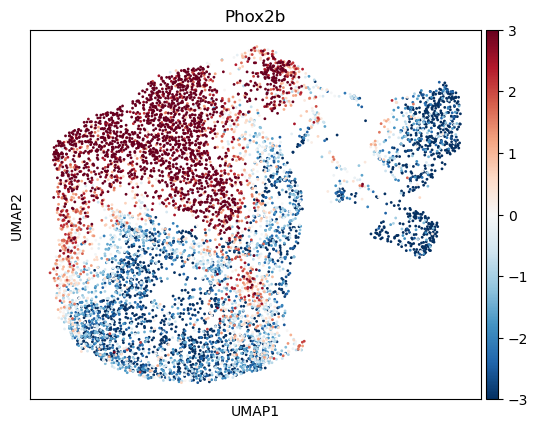

In [18]:
# First perform PCA to get PC loadings
sc.tl.pca(chromvar)

# Compute the UMAP embedding using scanpy's built-in function
sc.pp.neighbors(chromvar, use_rep='X_pca', metric='cosine', random_state=42)
sc.tl.umap(chromvar, random_state=42)

# Visualize clusters and cell-type-specific TF motif scores
sc.pl.umap(chromvar, color=['Phox2b'], cmap='RdBu_r', vmin=-3, vmax=3)

In [19]:
# vec.shape

In [20]:
chromvar.obsm["X_pca"].shape

(7418, 50)

In [21]:
chromvar.obsm["X_pca"][0:10, 0:10]

array([[ 3.91432037e+01,  1.98956661e+01,  5.64004064e-01,
         7.39499569e+00, -4.82722950e+00,  8.60441327e-01,
        -3.61401129e+00,  1.71169078e+00, -6.31981313e-01,
        -9.03582752e-01],
       [-2.98295460e+01,  1.60349636e+01,  1.85067444e+01,
         1.05905037e+01,  7.45827532e+00,  2.04503422e+01,
         1.19228563e+01, -4.95067596e+00,  5.84232855e+00,
        -1.81301677e+00],
       [ 1.13646431e+01, -1.80408621e+00,  8.04370213e+00,
         1.20030499e+01,  7.17820764e-01,  3.13257241e+00,
        -8.98782063e+00, -1.70642391e-01,  5.78820467e+00,
         5.08103907e-01],
       [ 1.80116045e+00, -2.35155866e-01, -2.08032485e-02,
         1.44945872e+00, -1.04092106e-01,  2.26934403e-01,
        -2.08033085e+00, -2.80728650e+00,  2.09464145e+00,
         5.09346962e-01],
       [ 1.49469767e+01, -8.76019211e+01,  2.73334732e+01,
         8.06310272e+00, -4.29551649e+00,  1.06346045e+01,
        -2.05352955e+01, -3.35943556e+00, -1.23484764e+01,
        -1.

## 4. Clustering of cells using Leiden

In [22]:
chromvar

AnnData object with n_obs × n_vars = 7418 × 890
    uns: 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

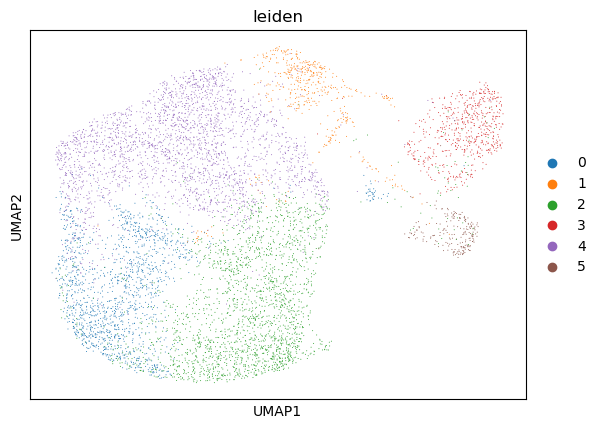

In [23]:
sc.pp.neighbors(chromvar)
sc.tl.leiden(chromvar, flavor="igraph", n_iterations=10, resolution=0.2, random_state=42)
sc.pl.umap(chromvar, color="leiden", size=2)

In [24]:
chromvar

AnnData object with n_obs × n_vars = 7418 × 890
    obs: 'leiden'
    uns: 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [25]:
chromvar.obs

,leiden
NT_AAACAGCCAGTTTCTC-1,0
NT_AAACGGATCAATAGCC-1,1
NT_AAACGGATCCTAATGA-1,2
NT_AAACGTACAAAGCCTC-1,2
NT_AAACGTACATGTGGGA-1,3
...,...
PBS_TTTGTGGCAATAAGCA-1,1
PBS_TTTGTGGCAGGACCAA-1,4
PBS_TTTGTGTTCCTAGTTT-1,0
PBS_TTTGTGTTCTGTTGCC-1,4


### 4.1 Visualize Prescott et al. 2020 labels on chromVAR UMAP

Load the barcode:subtype mapping metadata

In [26]:
# Read csv yes header

barcode_subtype_mapping_df = pd.read_csv(barcode_subtype_mapping_csv_file_path, header=0)

barcode_subtype_mapping_df

,Barcode,Cluster
0,NT_AAACAGCCAGTTTCTC-1,NG4
1,NT_AAACGGATCAATAGCC-1,JG6
2,NT_AAACGGATCCTAATGA-1,JG1
3,NT_AAACGTACAAAGCCTC-1,NG5
4,NT_AAACGTACATGTGGGA-1,JG1
...,...,...
7413,OVA_C_TTTGGTGCATTATCCC-1,JG4
7414,OVA_C_TTTGTGAAGTTATGTG-1,JG5
7415,OVA_C_TTTGTGGCAGAATGAC-1,JG1
7416,OVA_C_TTTGTGGCAGGTTACC-1,NG20


In [27]:
# Assuming barcode_subtype_mapping_df is already created and has columns 'Barcode' and 'Cluster'

# Set the index of barcode_subtype_mapping_df to 'Barcode' for easy matching
barcode_subtype_mapping_df_reindexed = barcode_subtype_mapping_df.set_index('Barcode', inplace=False)

# Reindex barcode_subtype_mapping_df to match the order of chromvar.obs_names
barcode_subtype_mapping_df_reindexed = barcode_subtype_mapping_df_reindexed.reindex(chromvar.obs_names)

# Add the 'Cluster' column to chromvar.obs
chromvar.obs['Cluster'] = barcode_subtype_mapping_df_reindexed['Cluster']

# Verify the addition
print(chromvar.obs.head())

                      leiden Cluster
NT_AAACAGCCAGTTTCTC-1      0     NG4
NT_AAACGGATCAATAGCC-1      1     JG6
NT_AAACGGATCCTAATGA-1      2     JG1
NT_AAACGTACAAAGCCTC-1      2     NG5
NT_AAACGTACATGTGGGA-1      3     JG1


... storing 'Cluster' as categorical


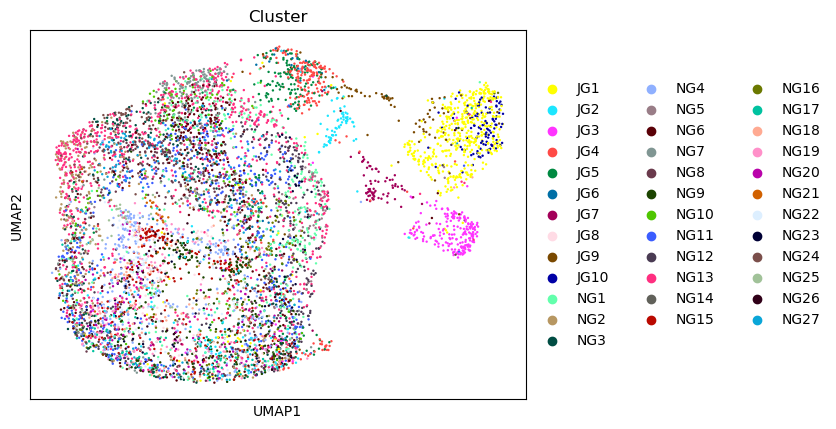

In [28]:
sc.pl.umap(chromvar, color="Cluster", size=12)

### 4.2 Visualize condition on UMAP

In [29]:
# Function to extract the sample name from the barcode
def extract_sample_name(barcode):
    parts = barcode.split('_')
    if len(parts) > 1:
        return '_'.join(parts[:-1])  # Join all parts except the last one
    else:
        return barcode.split('-')[0]

# Apply the function to extract sample names using a list comprehension
chromvar.obs['SampleName'] = [extract_sample_name(barcode) for barcode in chromvar.obs_names]


In [30]:
chromvar.obs

,leiden,Cluster,SampleName
NT_AAACAGCCAGTTTCTC-1,0,NG4,NT
NT_AAACGGATCAATAGCC-1,1,JG6,NT
NT_AAACGGATCCTAATGA-1,2,JG1,NT
NT_AAACGTACAAAGCCTC-1,2,NG5,NT
NT_AAACGTACATGTGGGA-1,3,JG1,NT
...,...,...,...
PBS_TTTGTGGCAATAAGCA-1,1,JG4,PBS
PBS_TTTGTGGCAGGACCAA-1,4,NG13,PBS
PBS_TTTGTGTTCCTAGTTT-1,0,NG13,PBS
PBS_TTTGTGTTCTGTTGCC-1,4,JG6,PBS


... storing 'SampleName' as categorical


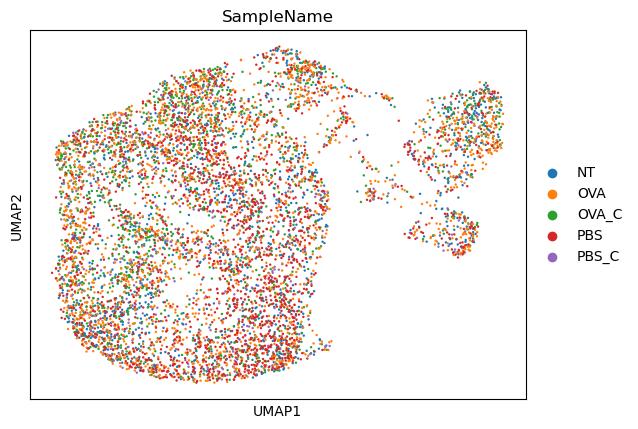

In [31]:
sc.pl.umap(chromvar, color="SampleName", size=12)

## 5. t-tests of motif scores

Function definition

In [32]:
import warnings
import os
import numpy as np
import pandas as pd
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Optional: try to import adjustText for repelling overlapping annotations.
try:
    from adjustText import adjust_text
except ImportError:
    adjust_text = None

def compare_subtypes(
    condition_str_1, 
    condition_str_2, 
    obs_df, 
    X, 
    var_names=None, 
    alpha=0.05, 
    dpi=300,
    save_fig=False,
    fig_path=None,
    show_plot=True
):
    """
    Compare motif scores between two celltype–sample subpopulations.
    
    The first condition is provided as a string (e.g. "JG1-OVA").
    The second condition can be either a string (e.g. "JG1-NT")
    or a list of strings (e.g. ["JG1-NT", "JG1-PBS", "JG1-PBS_C"]) in which case
    the control cells are lumped.
    
    This function:
      1. Filters obs_df and subsets X for each condition.
      2. Performs a per-motif two-sample t-test, then applies FDR correction.
      3. Returns a DataFrame sorted by descending t-statistic, 
         with columns: ['motif', 't_stat', 'p_val', 'p_val_adj', 'significance'].
      4. Generates a scatter plot of t-statistics by motif rank, colored by significance.
         Each dot has a thin black contour. To reduce clutter, only the top 5 significant motifs 
         (for Up and Down, respectively) are annotated with their motif name (small font, without arrows).
         If available, adjustText is used to repel overlapping labels.
         
    If either condition returns no cells, the analysis is skipped and None is returned.
    """
    
    # Helper: parse a condition string and return its subset.
    def get_subtype_data(condition_str, obs, X):
        try:
            cluster, sample = condition_str.split('-', 1)
        except ValueError:
            raise ValueError("Condition string must be in the format '<Cluster>-<SampleName>'.")
        
        subset_df = obs[(obs['Cluster'] == cluster) & (obs['SampleName'] == sample)].copy()
        if subset_df.empty:
            warnings.warn(f"No cells match the condition '{condition_str}'. Skipping analysis.")
            return None, None
        subset_df['original_row_number'] = subset_df.index.map(lambda idx: obs.index.get_loc(idx))
        try:
            X_subset = X[np.array(subset_df['original_row_number']).astype(int), :]
        except Exception as e:
            warnings.warn(f"Indexing error for condition '{condition_str}': {e}. Skipping analysis.")
            return None, None
        return subset_df, X_subset

    # Get data for the case.
    df1, X1 = get_subtype_data(condition_str_1, obs_df, X)
    if df1 is None:
        return None

    # For the control, allow either a single condition or a list (lumped controls).
    if isinstance(condition_str_2, list):
        control_dfs = []
        control_Xs = []
        for cond in condition_str_2:
            df_temp, X_temp = get_subtype_data(cond, obs_df, X)
            if df_temp is not None:
                control_dfs.append(df_temp)
                control_Xs.append(X_temp)
        if len(control_dfs) == 0:
            warnings.warn(f"No cells found for any of the control conditions {condition_str_2}.")
            return None
        df2 = pd.concat(control_dfs, axis=0)
        X2 = np.concatenate(control_Xs, axis=0)
    else:
        df2, X2 = get_subtype_data(condition_str_2, obs_df, X)
        if df2 is None:
            return None

    if X1.shape[1] != X2.shape[1]:
        raise ValueError("Both subpopulations must have the same number of motifs (columns).")
    
    num_motifs = X1.shape[1]
    if var_names is None:
        motif_names = [f"Motif_{i}" for i in range(num_motifs)]
    else:
        if len(var_names) != num_motifs:
            raise ValueError("Length of var_names must match the number of motif columns.")
        motif_names = var_names

    # Perform per-motif t-tests.
    t_stats, p_vals = [], []
    for i in range(num_motifs):
        scores1 = X1[:, i]
        scores2 = X2[:, i]
        t_stat, p_val = ttest_ind(scores1, scores2, equal_var=True)
        t_stats.append(t_stat)
        p_vals.append(p_val)
    
    # FDR correction.
    p_vals_adj = multipletests(p_vals, method='fdr_bh')[1]
    
    results_df = pd.DataFrame({
        'motif': motif_names,
        't_stat': t_stats,
        'p_val': p_vals,
        'p_val_adj': p_vals_adj
    })
    
    # Determine significance.
    significance_labels = []
    for _, row in results_df.iterrows():
        if row['p_val_adj'] < alpha:
            significance_labels.append("Up" if row['t_stat'] > 0 else "Down")
        else:
            significance_labels.append("Non-significant")
    results_df['significance'] = significance_labels
    results_df.sort_values('t_stat', ascending=False, inplace=True, ignore_index=True)
    
    # Color mapping.
    color_map = {"Up": "red", "Down": "blue", "Non-significant": "gray"}
    results_df['color'] = results_df['significance'].map(color_map)
    
    # Create scatter plot.
    plt.figure(dpi=dpi)
    plt.scatter(
        range(len(results_df)), 
        results_df['t_stat'], 
        c=results_df['color'], 
        edgecolors='black', linewidths=0.5
    )
    plt.axhline(0, color='black', linestyle='--')
    plt.ylabel("t-statistic")
    plt.xlabel("Motif rank (sorted by t-statistic)")
    plt.title(f"{condition_str_1} vs {condition_str_2 if isinstance(condition_str_2, str) else 'lumped controls'}")
    
    # Legend.
    legend_elements = [mpatches.Patch(color=color_map[label], label=label) for label in color_map]
    plt.legend(handles=legend_elements, loc='upper right')
    
    # Annotate only the top 5 significant motifs for each direction.
    texts = []
    up_df = results_df[results_df['significance'] == "Up"].sort_values('t_stat', ascending=False).head(5)
    down_df = results_df[results_df['significance'] == "Down"].sort_values('t_stat', ascending=True).head(5)
    
    for i, row in up_df.iterrows():
        txt = plt.annotate(
            row['motif'], (i, row['t_stat']),
            textcoords="offset points", xytext=(5, 5), ha='left', fontsize=8
        )
        texts.append(txt)
    for i, row in down_df.iterrows():
        txt = plt.annotate(
            row['motif'], (i, row['t_stat']),
            textcoords="offset points", xytext=(5, 5), ha='left', fontsize=8
        )
        texts.append(txt)
    
    if adjust_text is not None and texts:
        adjust_text(texts)
    
    if save_fig and fig_path:
        os.makedirs(os.path.dirname(fig_path), exist_ok=True)
        plt.savefig(fig_path, dpi=dpi, bbox_inches='tight')
    
    if show_plot:
        plt.show()
    else:
        plt.close()
    
    return results_df

def run_comparisons(obs_df, X, output_dir, clusters=None, comparisons=None, lump_controls=None, var_names=None, alpha=0.05, dpi=300):
    """
    Run motif score comparisons for multiple subtype pairs.
    
    If explicit comparisons are not provided, the function automatically
    generates comparisons for each cluster.
    
    By default, for each cluster the following six individual comparisons are generated:
      1) <Cluster>-OVA   vs   <Cluster>-NT  
      2) <Cluster>-OVA   vs   <Cluster>-PBS  
      3) <Cluster>-OVA   vs   <Cluster>-PBS_C  
      4) <Cluster>-OVA_C vs   <Cluster>-NT  
      5) <Cluster>-OVA_C vs   <Cluster>-PBS  
      6) <Cluster>-OVA_C vs   <Cluster>-PBS_C  
    
    Additionally, if lump_controls is provided (as a list of control sample names, e.g. ["NT", "PBS", "PBS_C"]),
    an extra comparison is added for each cluster in which the case (OVA or OVA_C) is compared to the lumped controls.
    """
    if clusters is None:
        clusters = np.unique(obs_df['Cluster'].astype(str))
    
    if comparisons is None:
        comparisons = []
        cases = ["OVA", "OVA_C"]
        controls = ["NT", "PBS", "PBS_C"]
        for cluster in clusters:
            # Individual comparisons.
            for case in cases:
                for control in controls:
                    comparisons.append((f"{cluster}-{case}", f"{cluster}-{control}"))
            # Add lumped control comparison if requested.
            if lump_controls is not None:
                for case in cases:
                    lumped_control = [f"{cluster}-{ctrl}" for ctrl in lump_controls]
                    comparisons.append((f"{cluster}-{case}", lumped_control))
    
    results_dict = {}
    os.makedirs(output_dir, exist_ok=True)
    
    for cond1, cond2 in comparisons:
        comp_label = f"{cond1}_vs_{cond2 if isinstance(cond2, str) else 'lumped'}"
        print(f"Running comparison: {comp_label}")
        comp_dir = os.path.join(output_dir, comp_label)
        os.makedirs(comp_dir, exist_ok=True)
        
        fig_path = os.path.join(comp_dir, f"{comp_label}_tstat_plot.png")
        table_path = os.path.join(comp_dir, f"{comp_label}_results.csv")
        
        results_df = compare_subtypes(
            cond1, cond2, obs_df, X, var_names=var_names, alpha=alpha, dpi=dpi,
            save_fig=True, fig_path=fig_path, show_plot=False
        )
        
        if results_df is None:
            print(f"Skipping comparison {comp_label} due to missing cells.")
            continue
        
        results_df.to_csv(table_path, index=False)
        results_dict[comp_label] = results_df
        
        print(f"Done! Results saved to: {table_path}")
        print('='*80)
    
    return results_dict

def summarize_results(results_dict, output_dir):
    """
    Generate a summary table that ranks comparisons by the total number of significantly enriched motifs.
    
    The summary table contains the following columns:
      - Comparison: The comparison label.
      - # significantly up: Number of motifs with significance 'Up'.
      - # significantly down: Number of motifs with significance 'Down'.
      - Total: Sum of up and down counts.
    
    The table is sorted in descending order by Total, and written as a CSV file in output_dir.
    """
    summary_rows = []
    for comp_label, df in results_dict.items():
        num_up = (df['significance'] == 'Up').sum()
        num_down = (df['significance'] == 'Down').sum()
        total = num_up + num_down
        summary_rows.append({
            'Comparison': comp_label,
            '# significantly up': num_up,
            '# significantly down': num_down,
            'Total': total
        })
    summary_df = pd.DataFrame(summary_rows)
    summary_df.sort_values('Total', ascending=False, inplace=True, ignore_index=True)
    summary_csv_path = os.path.join(output_dir, 'summary_comparisons.csv')
    summary_df.to_csv(summary_csv_path, index=False)
    return summary_df

# Example usage:
# For a single comparison:
# results_ova_nt = compare_subtypes("JG1-OVA", "JG1-NT", chromvar.obs, chromvar.X, var_names=list(chromvar.var_names))
#
# For multiple comparisons (including lumped controls):
# clusters_to_run = ["JG1", "NG11", "NG13"]
# results_dict = run_comparisons(
#     chromvar.obs, 
#     chromvar.X, 
#     output_dir="output/Prescott2020_subtype_comparisons", 
#     clusters=clusters_to_run, 
#     lump_controls=["NT", "PBS", "PBS_C"],  
#     var_names=list(chromvar.var_names)
# )
# summary_df = summarize_results(results_dict, "output/Prescott2020_subtype_comparisons")
# print(summary_df)

In [33]:
chromvar.var_names

Index(['AC1689771', 'Ahctf1', 'Ahr', 'Aire', 'Alx1', 'Alx3', 'Alx4', 'Ar',
       'Arid2', 'Arid3a',
       ...
       'Zkscan6', 'Zscan10', 'Zscan20', 'Zscan26', 'Zscan29', 'Zscan4b',
       'Zscan4c', 'Zscan4d', 'Zscan4f', 'Zzz3'],
      dtype='object', length=890)

### 5.1 Run case vs control for all subtypes

In [34]:
all_clusters_l = list(chromvar.obs['Cluster'].unique())

all_clusters_l

['NG4',
 'JG6',
 'JG1',
 'NG5',
 'NG11',
 'NG19',
 'NG25',
 'NG9',
 'NG16',
 'NG26',
 'NG6',
 'NG13',
 'NG12',
 'NG24',
 'NG15',
 'JG10',
 'NG2',
 'NG21',
 'NG1',
 'NG17',
 'NG10',
 'JG4',
 'NG8',
 'JG5',
 'NG22',
 'NG7',
 'JG3',
 'NG27',
 'JG9',
 'NG3',
 'NG23',
 'JG7',
 'NG18',
 'JG2',
 'NG20',
 'JG8',
 'NG14']

In [35]:
len(all_clusters_l)

37

In [36]:
output_dir

'/bap/bap/collab_asthma_multiome/ATAC/2_Analysis_Outputs/1d_chromvar_Outputs'

In [37]:
# Specify the clusters you wish to analyze.
results_dict_individual_controls = run_comparisons(
    chromvar.obs, 
    chromvar.X, 
    output_dir=os.path.join(output_dir, 'Prescott2020_subtype_comparisons_individual_controls'), 
    clusters=all_clusters_l, 
    var_names=list(chromvar.var_names)
)

Running comparison: NG4-OVA_vs_NG4-NT
Done! Results saved to: /bap/bap/collab_asthma_multiome/ATAC/2_Analysis_Outputs/1d_chromvar_Outputs/Prescott2020_subtype_comparisons_individual_controls/NG4-OVA_vs_NG4-NT/NG4-OVA_vs_NG4-NT_results.csv
Running comparison: NG4-OVA_vs_NG4-PBS
Done! Results saved to: /bap/bap/collab_asthma_multiome/ATAC/2_Analysis_Outputs/1d_chromvar_Outputs/Prescott2020_subtype_comparisons_individual_controls/NG4-OVA_vs_NG4-PBS/NG4-OVA_vs_NG4-PBS_results.csv
Running comparison: NG4-OVA_vs_NG4-PBS_C
4 [-0.25091976  0.90142861]
7 [0.46398788 0.19731697]
3 [-0.68796272 -0.68801096]
9 [-0.88383278  0.73235229]
Done! Results saved to: /bap/bap/collab_asthma_multiome/ATAC/2_Analysis_Outputs/1d_chromvar_Outputs/Prescott2020_subtype_comparisons_individual_controls/NG4-OVA_vs_NG4-PBS_C/NG4-OVA_vs_NG4-PBS_C_results.csv
Running comparison: NG4-OVA_C_vs_NG4-NT
Done! Results saved to: /bap/bap/collab_asthma_multiome/ATAC/2_Analysis_Outputs/1d_chromvar_Outputs/Prescott2020_subtype_

/tmp/ipykernel_1733798/1823983279.py:58: UserWarning: No cells match the condition 'JG6-PBS_C'. Skipping analysis.
  warnings.warn(f"No cells match the condition '{condition_str}'. Skipping analysis.")


Done! Results saved to: /bap/bap/collab_asthma_multiome/ATAC/2_Analysis_Outputs/1d_chromvar_Outputs/Prescott2020_subtype_comparisons_individual_controls/JG6-OVA_C_vs_JG6-NT/JG6-OVA_C_vs_JG6-NT_results.csv
Running comparison: JG6-OVA_C_vs_JG6-PBS
Done! Results saved to: /bap/bap/collab_asthma_multiome/ATAC/2_Analysis_Outputs/1d_chromvar_Outputs/Prescott2020_subtype_comparisons_individual_controls/JG6-OVA_C_vs_JG6-PBS/JG6-OVA_C_vs_JG6-PBS_results.csv
Running comparison: JG6-OVA_C_vs_JG6-PBS_C
Skipping comparison JG6-OVA_C_vs_JG6-PBS_C due to missing cells.
Running comparison: JG1-OVA_vs_JG1-NT


/tmp/ipykernel_1733798/1823983279.py:58: UserWarning: No cells match the condition 'JG6-PBS_C'. Skipping analysis.
  warnings.warn(f"No cells match the condition '{condition_str}'. Skipping analysis.")


Done! Results saved to: /bap/bap/collab_asthma_multiome/ATAC/2_Analysis_Outputs/1d_chromvar_Outputs/Prescott2020_subtype_comparisons_individual_controls/JG1-OVA_vs_JG1-NT/JG1-OVA_vs_JG1-NT_results.csv
Running comparison: JG1-OVA_vs_JG1-PBS
2 [0.20223002 0.41614516]
3 [-0.95883101  0.9398197 ]
Done! Results saved to: /bap/bap/collab_asthma_multiome/ATAC/2_Analysis_Outputs/1d_chromvar_Outputs/Prescott2020_subtype_comparisons_individual_controls/JG1-OVA_vs_JG1-PBS/JG1-OVA_vs_JG1-PBS_results.csv
Running comparison: JG1-OVA_vs_JG1-PBS_C
4 [ 0.66488528 -0.57532178]
7 [-0.63635007 -0.63319098]
Done! Results saved to: /bap/bap/collab_asthma_multiome/ATAC/2_Analysis_Outputs/1d_chromvar_Outputs/Prescott2020_subtype_comparisons_individual_controls/JG1-OVA_vs_JG1-PBS_C/JG1-OVA_vs_JG1-PBS_C_results.csv
Running comparison: JG1-OVA_C_vs_JG1-NT
Done! Results saved to: /bap/bap/collab_asthma_multiome/ATAC/2_Analysis_Outputs/1d_chromvar_Outputs/Prescott2020_subtype_comparisons_individual_controls/JG1-OV

/tmp/ipykernel_1733798/1823983279.py:58: UserWarning: No cells match the condition 'NG14-OVA'. Skipping analysis.
  warnings.warn(f"No cells match the condition '{condition_str}'. Skipping analysis.")
/tmp/ipykernel_1733798/1823983279.py:58: UserWarning: No cells match the condition 'NG14-OVA_C'. Skipping analysis.
  warnings.warn(f"No cells match the condition '{condition_str}'. Skipping analysis.")


In [38]:
results_dict_lumped_control = run_comparisons(
    chromvar.obs, 
    chromvar.X, 
    output_dir=os.path.join(output_dir, 'Prescott2020_subtype_comparisons_combine_controls'), 
    clusters=all_clusters_l, 
    lump_controls=["NT", "PBS", "PBS_C"],  # lump these controls together
    var_names=list(chromvar.var_names)
)

Running comparison: NG4-OVA_vs_NG4-NT
Done! Results saved to: /bap/bap/collab_asthma_multiome/ATAC/2_Analysis_Outputs/1d_chromvar_Outputs/Prescott2020_subtype_comparisons_combine_controls/NG4-OVA_vs_NG4-NT/NG4-OVA_vs_NG4-NT_results.csv
Running comparison: NG4-OVA_vs_NG4-PBS
Done! Results saved to: /bap/bap/collab_asthma_multiome/ATAC/2_Analysis_Outputs/1d_chromvar_Outputs/Prescott2020_subtype_comparisons_combine_controls/NG4-OVA_vs_NG4-PBS/NG4-OVA_vs_NG4-PBS_results.csv
Running comparison: NG4-OVA_vs_NG4-PBS_C
4 [ 0.36846605 -0.11969501]
7 [-0.75592353 -0.00964618]
0 [-0.93122296  0.8186408 ]
8 [-0.48244004  0.32504457]
Done! Results saved to: /bap/bap/collab_asthma_multiome/ATAC/2_Analysis_Outputs/1d_chromvar_Outputs/Prescott2020_subtype_comparisons_combine_controls/NG4-OVA_vs_NG4-PBS_C/NG4-OVA_vs_NG4-PBS_C_results.csv
Running comparison: NG4-OVA_C_vs_NG4-NT
Done! Results saved to: /bap/bap/collab_asthma_multiome/ATAC/2_Analysis_Outputs/1d_chromvar_Outputs/Prescott2020_subtype_compari

/tmp/ipykernel_1733798/1823983279.py:58: UserWarning: No cells match the condition 'JG6-PBS_C'. Skipping analysis.
  warnings.warn(f"No cells match the condition '{condition_str}'. Skipping analysis.")


Done! Results saved to: /bap/bap/collab_asthma_multiome/ATAC/2_Analysis_Outputs/1d_chromvar_Outputs/Prescott2020_subtype_comparisons_combine_controls/JG6-OVA_C_vs_JG6-NT/JG6-OVA_C_vs_JG6-NT_results.csv
Running comparison: JG6-OVA_C_vs_JG6-PBS
Done! Results saved to: /bap/bap/collab_asthma_multiome/ATAC/2_Analysis_Outputs/1d_chromvar_Outputs/Prescott2020_subtype_comparisons_combine_controls/JG6-OVA_C_vs_JG6-PBS/JG6-OVA_C_vs_JG6-PBS_results.csv
Running comparison: JG6-OVA_C_vs_JG6-PBS_C
Skipping comparison JG6-OVA_C_vs_JG6-PBS_C due to missing cells.
Running comparison: JG6-OVA_vs_lumped


/tmp/ipykernel_1733798/1823983279.py:58: UserWarning: No cells match the condition 'JG6-PBS_C'. Skipping analysis.
  warnings.warn(f"No cells match the condition '{condition_str}'. Skipping analysis.")
/tmp/ipykernel_1733798/1823983279.py:58: UserWarning: No cells match the condition 'JG6-PBS_C'. Skipping analysis.
  warnings.warn(f"No cells match the condition '{condition_str}'. Skipping analysis.")


Done! Results saved to: /bap/bap/collab_asthma_multiome/ATAC/2_Analysis_Outputs/1d_chromvar_Outputs/Prescott2020_subtype_comparisons_combine_controls/JG6-OVA_vs_lumped/JG6-OVA_vs_lumped_results.csv
Running comparison: JG6-OVA_C_vs_lumped


/tmp/ipykernel_1733798/1823983279.py:58: UserWarning: No cells match the condition 'JG6-PBS_C'. Skipping analysis.
  warnings.warn(f"No cells match the condition '{condition_str}'. Skipping analysis.")


Done! Results saved to: /bap/bap/collab_asthma_multiome/ATAC/2_Analysis_Outputs/1d_chromvar_Outputs/Prescott2020_subtype_comparisons_combine_controls/JG6-OVA_C_vs_lumped/JG6-OVA_C_vs_lumped_results.csv
Running comparison: JG1-OVA_vs_JG1-NT
Done! Results saved to: /bap/bap/collab_asthma_multiome/ATAC/2_Analysis_Outputs/1d_chromvar_Outputs/Prescott2020_subtype_comparisons_combine_controls/JG1-OVA_vs_JG1-NT/JG1-OVA_vs_JG1-NT_results.csv
Running comparison: JG1-OVA_vs_JG1-PBS
2 [-0.37657785  0.04013604]
3 [ 0.09342056 -0.63029109]
Done! Results saved to: /bap/bap/collab_asthma_multiome/ATAC/2_Analysis_Outputs/1d_chromvar_Outputs/Prescott2020_subtype_comparisons_combine_controls/JG1-OVA_vs_JG1-PBS/JG1-OVA_vs_JG1-PBS_results.csv
Running comparison: JG1-OVA_vs_JG1-PBS_C
4 [0.93916926 0.55026565]
7 [0.87899788 0.7896547 ]
Done! Results saved to: /bap/bap/collab_asthma_multiome/ATAC/2_Analysis_Outputs/1d_chromvar_Outputs/Prescott2020_subtype_comparisons_combine_controls/JG1-OVA_vs_JG1-PBS_C/JG1

/tmp/ipykernel_1733798/1823983279.py:58: UserWarning: No cells match the condition 'NG14-OVA'. Skipping analysis.
  warnings.warn(f"No cells match the condition '{condition_str}'. Skipping analysis.")
/tmp/ipykernel_1733798/1823983279.py:58: UserWarning: No cells match the condition 'NG14-OVA_C'. Skipping analysis.
  warnings.warn(f"No cells match the condition '{condition_str}'. Skipping analysis.")


In [39]:
summary_df_individual_controls = summarize_results(results_dict_individual_controls, 
                                                   os.path.join(output_dir, 'Prescott2020_subtype_comparisons_individual_controls'))

summary_df_lumped_controls = summarize_results(results_dict_lumped_control, 
                                                   os.path.join(output_dir, 'Prescott2020_subtype_comparisons_combine_controls'))


In [45]:
results_dict_individual_controls.keys()

dict_keys(['NG4-OVA_vs_NG4-NT', 'NG4-OVA_vs_NG4-PBS', 'NG4-OVA_vs_NG4-PBS_C', 'NG4-OVA_C_vs_NG4-NT', 'NG4-OVA_C_vs_NG4-PBS', 'NG4-OVA_C_vs_NG4-PBS_C', 'JG6-OVA_vs_JG6-NT', 'JG6-OVA_vs_JG6-PBS', 'JG6-OVA_C_vs_JG6-NT', 'JG6-OVA_C_vs_JG6-PBS', 'JG1-OVA_vs_JG1-NT', 'JG1-OVA_vs_JG1-PBS', 'JG1-OVA_vs_JG1-PBS_C', 'JG1-OVA_C_vs_JG1-NT', 'JG1-OVA_C_vs_JG1-PBS', 'JG1-OVA_C_vs_JG1-PBS_C', 'NG5-OVA_vs_NG5-NT', 'NG5-OVA_vs_NG5-PBS', 'NG5-OVA_vs_NG5-PBS_C', 'NG5-OVA_C_vs_NG5-NT', 'NG5-OVA_C_vs_NG5-PBS', 'NG5-OVA_C_vs_NG5-PBS_C', 'NG11-OVA_vs_NG11-NT', 'NG11-OVA_vs_NG11-PBS', 'NG11-OVA_vs_NG11-PBS_C', 'NG11-OVA_C_vs_NG11-NT', 'NG11-OVA_C_vs_NG11-PBS', 'NG11-OVA_C_vs_NG11-PBS_C', 'NG19-OVA_vs_NG19-NT', 'NG19-OVA_vs_NG19-PBS', 'NG19-OVA_vs_NG19-PBS_C', 'NG19-OVA_C_vs_NG19-NT', 'NG19-OVA_C_vs_NG19-PBS', 'NG19-OVA_C_vs_NG19-PBS_C', 'NG25-OVA_vs_NG25-NT', 'NG25-OVA_vs_NG25-PBS', 'NG25-OVA_vs_NG25-PBS_C', 'NG25-OVA_C_vs_NG25-NT', 'NG25-OVA_C_vs_NG25-PBS', 'NG25-OVA_C_vs_NG25-PBS_C', 'NG9-OVA_vs_NG9-NT', 'N

In [44]:
results_dict_lumped_control.keys()

dict_keys(['NG4-OVA_vs_NG4-NT', 'NG4-OVA_vs_NG4-PBS', 'NG4-OVA_vs_NG4-PBS_C', 'NG4-OVA_C_vs_NG4-NT', 'NG4-OVA_C_vs_NG4-PBS', 'NG4-OVA_C_vs_NG4-PBS_C', 'NG4-OVA_vs_lumped', 'NG4-OVA_C_vs_lumped', 'JG6-OVA_vs_JG6-NT', 'JG6-OVA_vs_JG6-PBS', 'JG6-OVA_C_vs_JG6-NT', 'JG6-OVA_C_vs_JG6-PBS', 'JG6-OVA_vs_lumped', 'JG6-OVA_C_vs_lumped', 'JG1-OVA_vs_JG1-NT', 'JG1-OVA_vs_JG1-PBS', 'JG1-OVA_vs_JG1-PBS_C', 'JG1-OVA_C_vs_JG1-NT', 'JG1-OVA_C_vs_JG1-PBS', 'JG1-OVA_C_vs_JG1-PBS_C', 'JG1-OVA_vs_lumped', 'JG1-OVA_C_vs_lumped', 'NG5-OVA_vs_NG5-NT', 'NG5-OVA_vs_NG5-PBS', 'NG5-OVA_vs_NG5-PBS_C', 'NG5-OVA_C_vs_NG5-NT', 'NG5-OVA_C_vs_NG5-PBS', 'NG5-OVA_C_vs_NG5-PBS_C', 'NG5-OVA_vs_lumped', 'NG5-OVA_C_vs_lumped', 'NG11-OVA_vs_NG11-NT', 'NG11-OVA_vs_NG11-PBS', 'NG11-OVA_vs_NG11-PBS_C', 'NG11-OVA_C_vs_NG11-NT', 'NG11-OVA_C_vs_NG11-PBS', 'NG11-OVA_C_vs_NG11-PBS_C', 'NG11-OVA_vs_lumped', 'NG11-OVA_C_vs_lumped', 'NG19-OVA_vs_NG19-NT', 'NG19-OVA_vs_NG19-PBS', 'NG19-OVA_vs_NG19-PBS_C', 'NG19-OVA_C_vs_NG19-NT', 'NG19-O

In [40]:
summary_df_individual_controls

,Comparison,# significantly up,# significantly down,Total
0,JG3-OVA_vs_JG3-PBS_C,329,134,463
1,NG6-OVA_C_vs_NG6-PBS,174,126,300
2,JG1-OVA_C_vs_JG1-PBS,100,172,272
3,NG13-OVA_vs_NG13-PBS_C,74,182,256
4,JG4-OVA_C_vs_JG4-PBS_C,122,123,245
...,...,...,...,...
209,JG10-OVA_C_vs_JG10-PBS,0,0,0
210,NG2-OVA_vs_NG2-NT,0,0,0
211,NG2-OVA_vs_NG2-PBS,0,0,0
212,NG21-OVA_vs_NG21-NT,0,0,0


In [41]:
summary_df_lumped_controls

,Comparison,# significantly up,# significantly down,Total
0,JG3-OVA_vs_JG3-PBS_C,329,134,463
1,NG6-OVA_C_vs_NG6-PBS,174,126,300
2,JG1-OVA_C_vs_JG1-PBS,100,172,272
3,NG13-OVA_vs_NG13-PBS_C,74,182,256
4,JG4-OVA_C_vs_JG4-PBS_C,122,123,245
...,...,...,...,...
281,NG2-OVA_vs_NG2-PBS,0,0,0
282,NG2-OVA_vs_lumped,0,0,0
283,NG21-OVA_vs_NG21-NT,0,0,0
284,NG21-OVA_vs_NG21-PBS,0,0,0


## Close object

In [42]:
# printer.close()

In [43]:
print('Done')

Done


# END
